In [135]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

Вот так загружаем с локального диска

In [3]:
from google.colab import files

uploaded = files.upload()



Saving small_segment.rar to small_segment.rar


Открываем архив (это зависит от архива)

In [11]:
!pip install rarfile

     |████████████████████████████████| 122kB 9.2MB/s 
  Created wheel for rarfile: filename=rarfile-3.1-cp36-none-any.whl size=24908 sha256=b4e3c792c972c2659f89f79ff68c9908983958b14c653e0f1aa57b0c43644cee
  Stored in directory: /root/.cache/pip/wheels/23/3c/c8/0215b6a5079492eff3be3f545ae0b0c4a66734c35c9e444eac
Successfully built rarfile


In [18]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels 0
images 0


In [15]:
!ls

sample_data  small_segment.rar


А вот так загрузим картинки с Гугл Диска (делаем только один вариант загрузки)

In [14]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [19]:
!ls

images	labels	sample_data  small_segment.rar


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

In [23]:
import os, fnmatch
imag = os.listdir('/content/images')
imag_label = os.listdir('/content/labels')

In [24]:
imag,imag_label

(['00_001400.png',
  '00_003000.png',
  '00_002400.png',
  '00_001600.png',
  '00_001200.png',
  '00_003400.png',
  '00_002000.png',
  '00_001800.png',
  '00_000600.png',
  '00_002200.png',
  '00_000800.png',
  '00_000200.png',
  '00_000400.png',
  '00_002800.png',
  '00_002600.png',
  '00_003200.png',
  '00_001000.png'],
 ['00_001400.png',
  '00_003000.png',
  '00_002400.png',
  '00_001600.png',
  '00_001200.png',
  '00_003400.png',
  '00_002000.png',
  '00_001800.png',
  '00_000600.png',
  '00_002200.png',
  '00_000800.png',
  '00_000200.png',
  '00_000400.png',
  '00_002800.png',
  '00_002600.png',
  '00_003200.png',
  '00_001000.png'])

Задаю маршрут для чтения

In [75]:
PAHT_label = '/content/labels/'
PAHT_image = '/content/images/'
  

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [76]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


Посмотрели на входные кадры

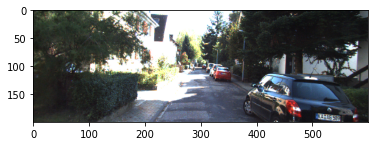

In [77]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

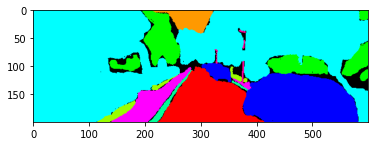

In [78]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [102]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [103]:
print(xTrain.shape)

(17, 200, 600, 3)


In [36]:
import cv2

Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

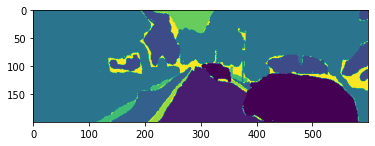

In [195]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


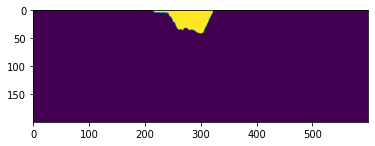

In [196]:
plt.imshow(cat_yi[:,:,10])
plt.show()

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [197]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [198]:
print(yTrain_Test.shape)

(17, 200, 600, 14)


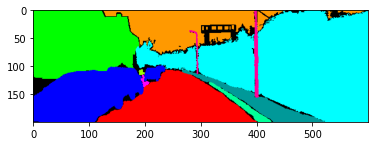

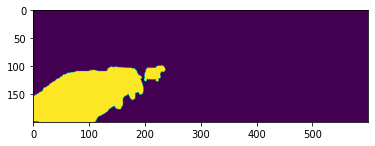

In [199]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [200]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [201]:
yTest.shape

(2, 200, 600, 14)

In [202]:
print(xTrain.shape)
print(yTrain.shape)

(15, 200, 600, 3)
(15, 200, 600, 14)


#Создаём и обучаем U-net

In [203]:
from tensorflow.keras.utils import plot_model

**Unet**

In [204]:
def cuttedUnet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 200, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_101 (Activation)     (None, 200, 600, 64) 0           batch_normalization_101[0][0]    
____________________________________________________________________________________________

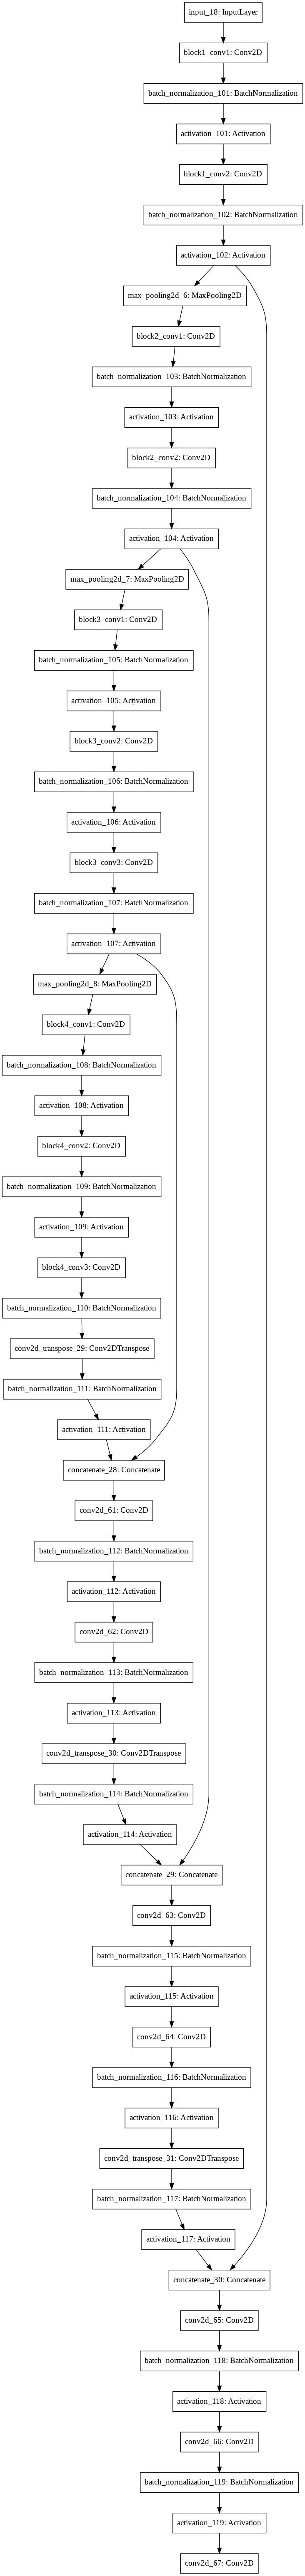

In [205]:
modelC = cuttedUnet(14, (200, 600, 3))

plot_model(modelC, to_file='modelC.png')

In [208]:

history = modelC.fit(xTrain, yTrain, epochs=30, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/30
5/5 [==============================] - 2s 498ms/step - loss: 0.6793 - dice_coef: 0.6599 - val_loss: 9.5167 - val_dice_coef: 0.2223
Epoch 2/30
5/5 [==============================] - 2s 492ms/step - loss: 0.7000 - dice_coef: 0.6606 - val_loss: 7.3197 - val_dice_coef: 0.3117
Epoch 3/30
5/5 [==============================] - 2s 497ms/step - loss: 0.6498 - dice_coef: 0.6692 - val_loss: 7.7765 - val_dice_coef: 0.2819
Epoch 4/30
5/5 [==============================] - 2s 498ms/step - loss: 0.6105 - dice_coef: 0.6935 - val_loss: 7.2256 - val_dice_coef: 0.2934
Epoch 5/30
5/5 [==============================] - 2s 497ms/step - loss: 0.5903 - dice_coef: 0.7063 - val_loss: 7.4484 - val_dice_coef: 0.2797
Epoch 6/30
5/5 [==============================] - 3s 505ms/step - loss: 0.5839 - dice_coef: 0.7097 - val_loss: 4.9466 - val_dice_coef: 0.4105
Epoch 7/30
5/5 [==============================] - 3s 504ms/step - loss: 0.6617 - dice_coef: 0.6928 - val_loss: 3.5330 - val_dice_coef: 0.4217
Epoch 

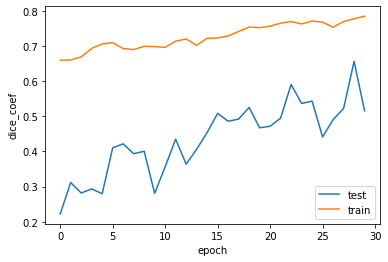

In [209]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [210]:
pred = modelC.predict(xTest)
print(pred.shape)

(2, 200, 600, 14)


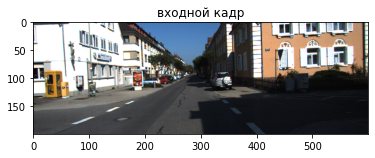

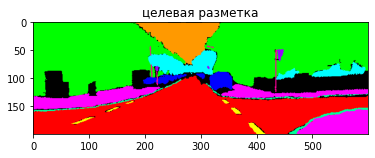

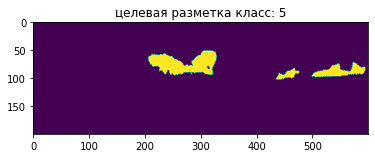

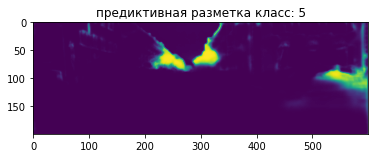

In [226]:
n = 0
class_ =5
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

**Претренированная  Unet**

In [136]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [137]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 150, 128)      0     

In [245]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Tensor("block3_pool_16/Identity:0", shape=(None, 25, 75, 256), dtype=float32)
Tensor("block2_pool_16/Identity:0", shape=(None, 50, 150, 128), dtype=float32)
Tensor("block1_pool_16/Identity:0", shape=(None, 100, 300, 64), dtype=float32)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_21[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 200, 600, 64) 36928       block1_conv1[0][0]               
_____________________________________________________

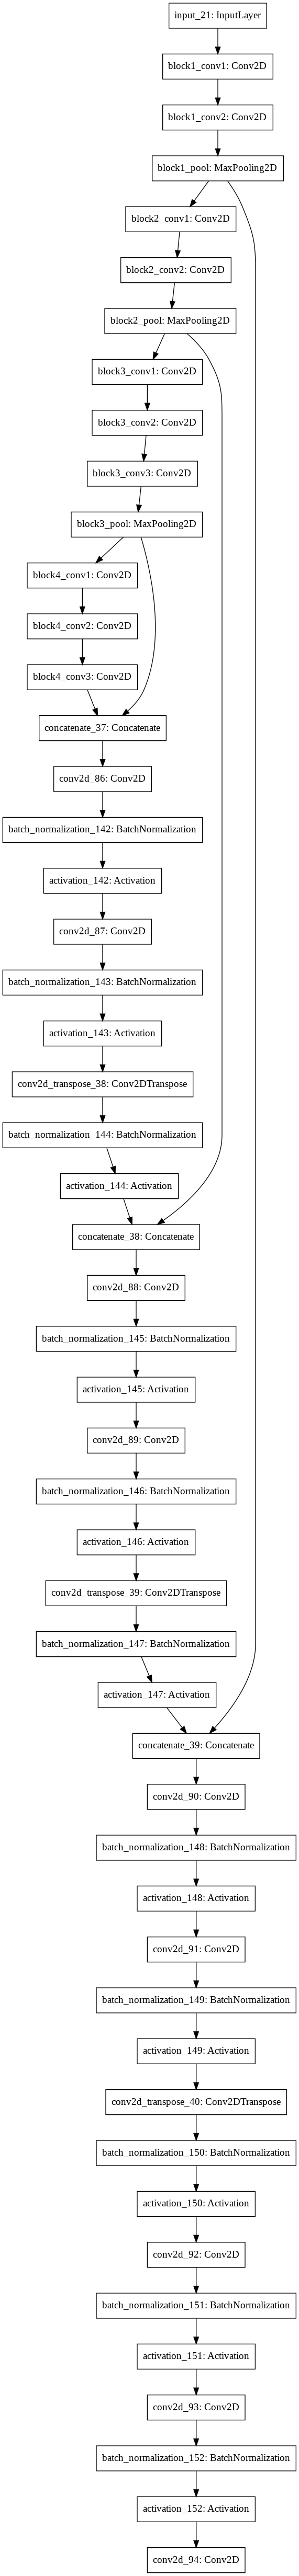

In [246]:
modelU = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

plot_model(modelU, to_file='modelU.png')

In [248]:
history = modelU.fit(xTrain, yTrain, epochs=30, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/30
5/5 [==============================] - 2s 362ms/step - loss: 0.6724 - dice_coef: 0.6751 - val_loss: 1.3539 - val_dice_coef: 0.4618
Epoch 2/30
5/5 [==============================] - 2s 361ms/step - loss: 0.7082 - dice_coef: 0.6643 - val_loss: 1.3152 - val_dice_coef: 0.5034
Epoch 3/30
5/5 [==============================] - 2s 362ms/step - loss: 0.6598 - dice_coef: 0.6681 - val_loss: 0.9797 - val_dice_coef: 0.5944
Epoch 4/30
5/5 [==============================] - 2s 364ms/step - loss: 0.5753 - dice_coef: 0.7101 - val_loss: 0.8798 - val_dice_coef: 0.6112
Epoch 5/30
5/5 [==============================] - 2s 364ms/step - loss: 0.6148 - dice_coef: 0.6963 - val_loss: 1.2827 - val_dice_coef: 0.5320
Epoch 6/30
5/5 [==============================] - 2s 362ms/step - loss: 0.5775 - dice_coef: 0.7141 - val_loss: 1.1484 - val_dice_coef: 0.5784
Epoch 7/30
5/5 [==============================] - 2s 364ms/step - loss: 0.5672 - dice_coef: 0.7118 - val_loss: 1.3142 - val_dice_coef: 0.4829
Epoch 

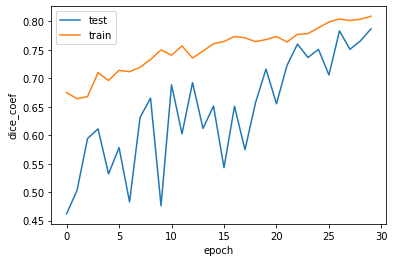

In [249]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [250]:
predu = modelU.predict(xTest)
print(pred.shape)


(2, 200, 600, 14)


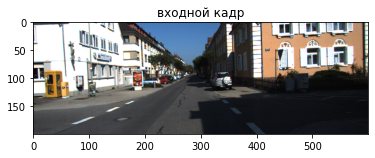

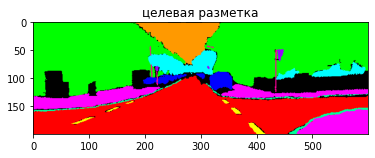

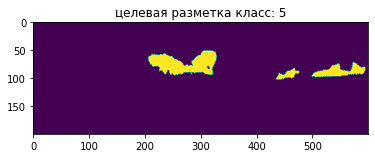

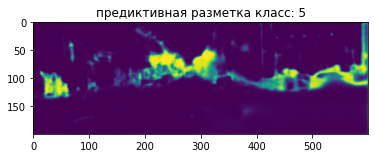

In [254]:
n = 0
class_ = 5
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


Что еще делаем:

- аугментацию
- ищем новые примеры
- проверяем разметку
- меняем модель